# 4. LassoLars

The Lasso is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer parameter values, effectively reducing the number of variables upon which the given solution is dependent. For this reason, the Lasso and its variants are fundamental to the field of compressed sensing. Under certain conditions, it can recover the exact set of non-zero weights.
Mathematically, it consists of a linear model trained with $l_1$ prior as regularizer. The objective function to minimize is:

$$
\min_{w} \  {1\over{2n_{samples}}} ||Xw-y||_{2} ^2 + \alpha||w||_{1}
$$

The lasso estimate thus solves the minimization of the least-squares penalty with $\alpha||w||_{1}$ added, where $\alpha$ is a constant and $||w||_{1}$ is the $l_1$-norm of the parameter vector.

LassoLarsCV is based on the Least Angle Regression algorithm. LassoLarsCV has the advantage of exploring more relevant values of alpha parameter, and if the number of samples is very small compared to the number of features, it is often faster than LassoCV.

### Least-angle regression (LARS)

Least-angle regression (LARS) is a regression algorithm for high-dimensional data, developed by Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani. LARS is similar to forward stepwise regression. At each step, it finds the predictor most correlated with the response. When there are multiple predictors having equal correlation, instead of continuing along the same predictor, it proceeds in a direction equiangular between the predictors.

The advantages of LARS are:

- It is numerically efficient in contexts where p >> n (i.e., when the number of dimensions is significantly greater than the number of points).
- It is computationally just as fast as forward selection and has the same order of complexity as an ordinary least squares.
- It produces a full piecewise linear solution path, which is useful in cross-validation or similar attempts to tune the model.
- If two variables are almost equally correlated with the response, then their coefficients should increase at approximately the same rate. The algorithm thus behaves as intuition would expect, and also is more stable.
- It is easily modified to produce solutions for other estimators, like the Lasso.

The disadvantages of the LARS method include:

- Because LARS is based upon an iterative refitting of the residuals, it would appear to be especially sensitive to the effects of noise.

The algorithm is similar to forward stepwise regression, but instead of including variables at each step, the estimated parameters are increased in a direction equiangular to each one’s correlations with the residual.

Instead of giving a vector result, the LARS solution consists of a curve denoting the solution for each value of the L1 norm of the parameter vector. The full coefficients path is stored in the array $\textit{coef_path_}$, which has size (n_features, max_features+1).

In [8]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import sklearn.linear_model as sklm
import scipy

kb = 1.38064e-23  # постоянная Больцмана
T = 273.15 + 22  # температура в K
theta = np.pi / 2  # угол рассеяния
n = 1.333  # показатель преломления
eta = 0.958e-3  # Н * с/м^2 - динамическая вязкость воды
l = 650e-9  # Длина волны лазера

coeff = (kb * T / (3 * np.pi * eta)) * (4 * np.pi * n / l) ** 2 * np.sin(theta / 2) ** 2

In [9]:
# диапазон размеров частиц, где ищем нужный размер 
d_min = 1e-9 # 1 нм
d_max = 1e-6 

# задаем сетку по Gamma
G_min = coeff/d_max
G_max = coeff/d_min
N = 256*8 # Число узлов в сетке по \Gamma

w = 2.0*np.arange(1,5001)
M = w.size # Число точек по частоте
p = (G_max/G_min)**(1/(N-1))
G = np.zeros(N)

# неравномерная сетка со сгущением к нулю (так как больщий вклад в интенсивность дают крупные частицы)
# хотя такая сетка - это не единственно возможный вариант
for j in range(N):
    G[j] = G_min * (p**j)

# вот равномерная сетка
#G = np.linspace(G_min, G_max, N)    

A = np.zeros((M,N))

# Матрица коэффициентов (составляется по базисным ф-ям)
for i in range(M):
    for j in range(N):
        A[i,j] = G[j] / ((2 * np.pi * w[i])**2 + G[j]**2)  

In [10]:
# Функция для построения для одного примера
import scipy.signal

def draw_given(w, d1, d2, i, y, y1 = [], y2 = []):
    fig = plt.figure()
    ax1 = plt.subplot(N_samples,2,2*i+1)
    
    if (len(y1) != 0): 
        plt.plot(w, y1, 'darkblue')
    if (len(y2) != 0): 
        plt.plot(w, y2, 'blue')
    
    plt.plot(w, y, 'red')
    #Вывод уже умножив на 1e+9
    ax1.set_title('Peaks given: [{0:.0f}, {1:.0f}]'.format(d1 * 1e+9, d2 * 1e+9)) # {0:2.0e}
    ax1.set_xlabel('Frequency')
    
def draw_found(w, i, y):
    clf = sklm.LassoLarsCV()
    clf.fit(A, y)
    a = clf.coef_
    
    ax2 = plt.subplot(N_samples,2,2*i+2)
    line, = plt.plot(1e+9 * coeff/G, a,'.-')
    ax2.set_xscale('log')
    plt.xlim(d_min*1e9, d_max*1e9)
    ax2.set_xlabel('Diameter, *10e-9')
    
    indexes, _ = scipy.signal.find_peaks(a, height=0.02, distance=10) #height нужно задавать правильный
    peaks = sorted(1e+9*coeff/G[indexes])
    if (len(peaks) == 2):
        ax2.set_title('Peaks found: [{0:.0f}, {1:.0f}]'.format(peaks[0], peaks[1])) # 'Peaks found: %s' % (1e+9*coeff/G[indexes])
    elif (len(peaks) == 3):
        ax2.set_title('Peaks found: [{0:.0f}, {1:.0f}, {2:.0f}]'.format(peaks[0], peaks[1], peaks[2]))
    else:
        ax2.set_title('Peak found: [{0:.0f}]'.format(peaks[0]))

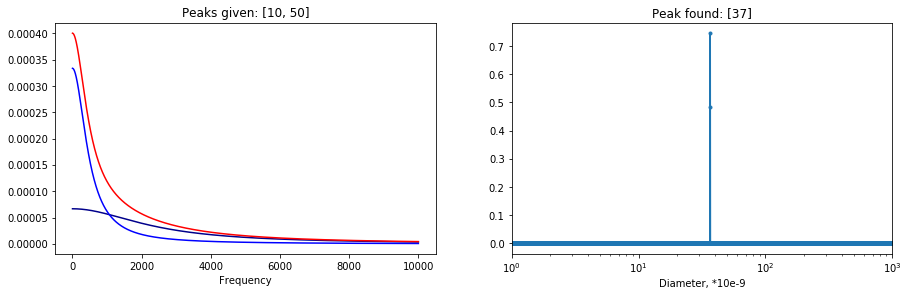

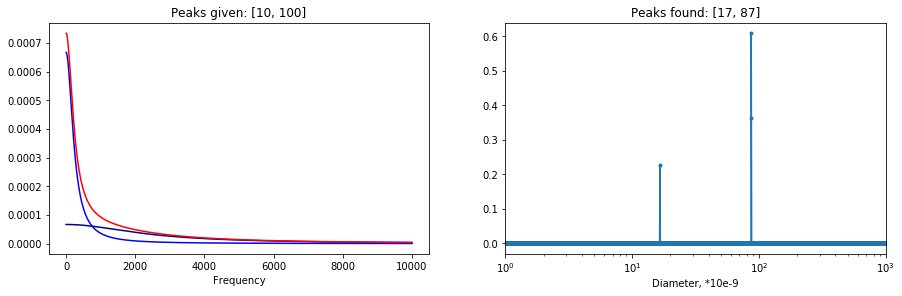

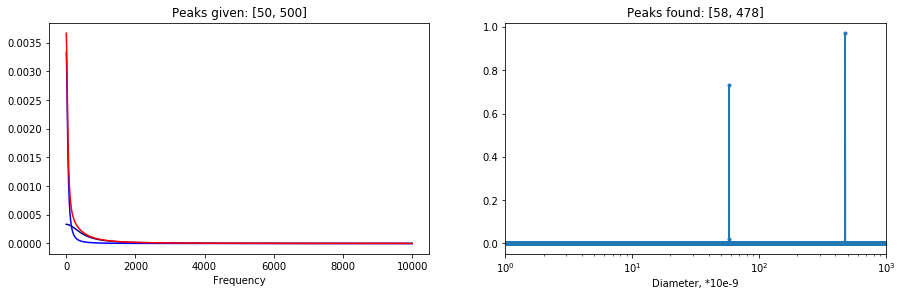

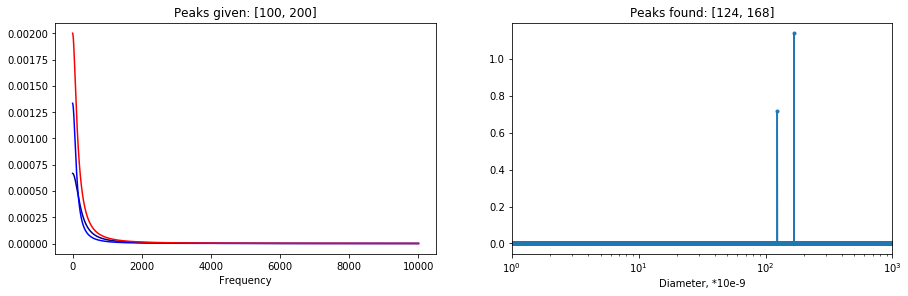

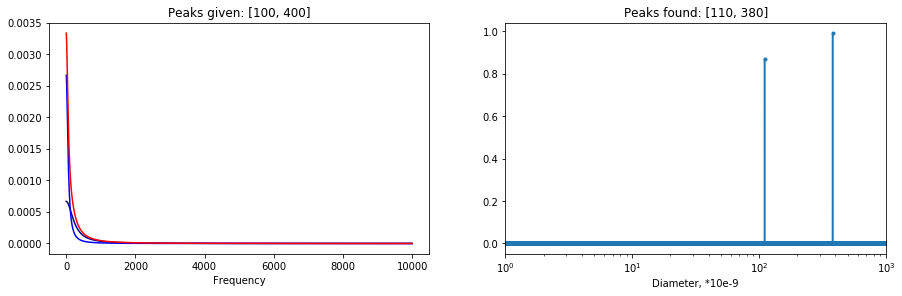

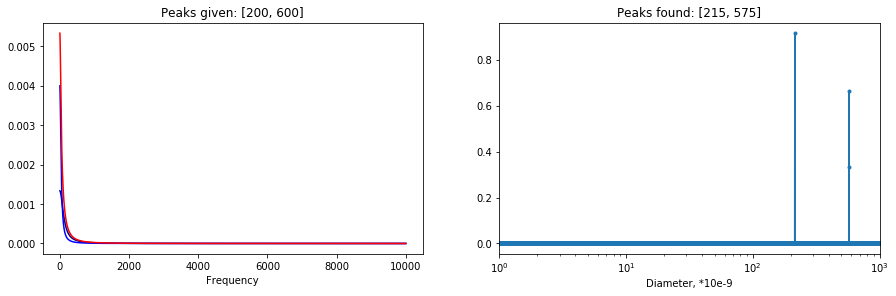

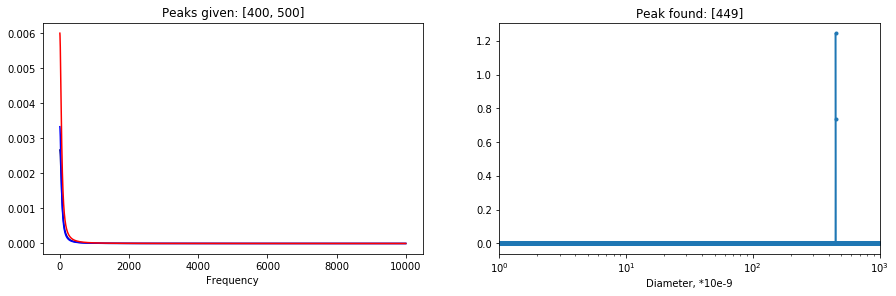

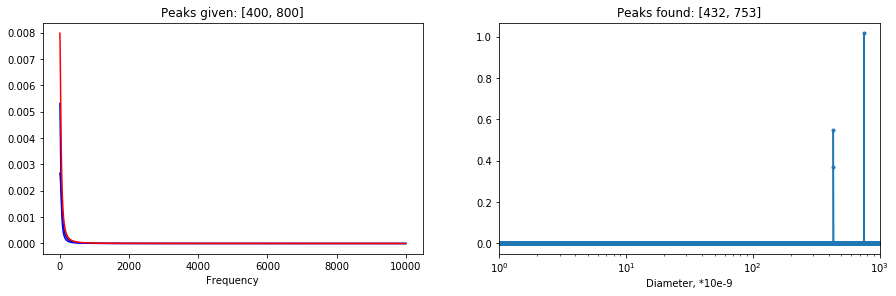

In [11]:
# Set samples
N_samples = 8

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15 #width
fig_size[1] = 5 * N_samples #height
plt.rcParams["figure.figsize"] = fig_size

d1_mass = [10, 10, 50, 100, 100, 200, 400, 400] 
d1_mass = [sample * 1e-9 for sample in d1_mass]

d2_mass = [50, 100, 500, 200, 400, 600, 500, 800]
d2_mass = [sample * 1e-9 for sample in d2_mass]

G1_mass = coeff / d1_mass
G2_mass = coeff / d2_mass

y_mass = np.zeros((N_samples, w.size))

for i in range(N_samples):
    y1 = G1_mass[i] / ((2 * np.pi * w)**2 + G1_mass[i]**2)
    y2 = G2_mass[i] / ((2 * np.pi * w)**2 + G2_mass[i]**2)
    y_mass[i,:] = y1 + y2

    draw_given(w, d1_mass[i], d2_mass[i], i, y_mass[i,:], y1, y2)
    draw_found(w, i, y_mass[i,:])